# Local Discriminant Basis as Feature Extractor

Local Discriminant Basis is a feature extraction technique developed by N. Saito and R. Coifman in 1995. This algorithm follows the following basic steps:

1. Decompose a set of multi-class signals using wavelet packet decomposition. A wavelet packet decomposition decomposes a signal into multiple nodes which resembles a binary tree.
2. Based on the decomposed wavelet coefficients, build an energy map based on time-frequency or probability density.
3. Using the energy map, compute the discriminant measure and select a basis tree that best discriminates the different classes of signals.
4. Based on the selected basis tree, extract the corresponding wavelet coefficients for each signal.
5. Compute the discriminant power of each coefficient index. Select the top k set of coefficients to be used as features to be passed onto a classifier such as Linear Discriminant Analysis (LDA) and Classification and Regression Trees (CART).

A more in-depth tutorial can be found in the Pluto notebook [here](https://github.com/ShozenD/LDBExperiments). For more information on LDB, please refer to the original paper "Local Discriminant Basis and their Applications" by Saito and Coifman [here](https://www.math.ucdavis.edu/~saito/publications/saito_ldb_jmiv.pdf).

In [1]:
# change directory to data/
cd("./../data")
pwd()

"C:\\Users\\LZFun\\Documents\\MicroscopyImageClassification\\data"

## Import images

In [2]:
using DataFrames, CSV

df = CSV.read("labels-files.csv", DataFrame)
first(df, 5)

5×4 DataFrame
 Row │ label           label_idx  file                      path               ⋯
     │ String          Int64      String                    String             ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ cell periphery          0  001013000-0-13873-1.png   cell periphery/001 ⋯
   2 │ cell periphery          0  001013000-0-13873-10.png  cell periphery/001
   3 │ cell periphery          0  001013000-0-13873-11.png  cell periphery/001
   4 │ cell periphery          0  001013000-0-13873-12.png  cell periphery/001
   5 │ cell periphery          0  001013000-0-13873-13.png  cell periphery/001 ⋯
                                                                1 column omitted

In [3]:
groupby(df, :label_idx) |> y -> combine(y, nrow)

12×2 DataFrame
 Row │ label_idx  nrow  
     │ Int64      Int64 
─────┼──────────────────
   1 │         0   9454
   2 │         1   9434
   3 │         2   4078
   4 │         3   9343
   5 │         4   3360
   6 │         5   9350
   7 │         6   9077
   8 │         7   9424
   9 │         8   9379
  10 │         9   2141
  11 │        10   7011
  12 │        11   7949

In [4]:
using Images

# Remove a semicolon below to observe the outputs
img = load(df[1,4])
Float64.(red.(img));  # red signals
Float64.(blue.(img)); # blue signals
Float64.(green.(img));# green signals

In [5]:
# read images
N = 22966  # only reads in the first 3 classes of images
X = Array{Float64, 4}(undef, (64, 64, 3, N))
y = Vector{Int64}(undef, (N))
for i in 1:N
    img = load(df[i,4])
    X[:,:,:,i] = Float64.(cat(red.(img), green.(img), blue.(img), dims=3))
    y[i] = df[i,2]
end

**Note:** Unlike Python, where matrices are row-based, Julia's matrices are column based. This means that instead of each row being an individual signal, we have each column as an individual signal.

In [6]:
# play with individual color channels (1: red, 2: green, 3: blue)
channel = 2
X̂ = X[:,:,channel,:];
size(X̂)

(64, 64, 22966)

In [7]:
# convert images to 1-d signals
X̂ = reshape(X̂, (:, N));
size(X̂)

(4096, 22966)

## View the signals


Rerun the following cell multiple times to observe the signal representations of each class of images.

In [8]:
using StatsBase, Wavelets, WaveletsExt, Plots

idx = Vector{Int64}(undef, 15)
for i in 0:2
    label_idx = findall(yᵢ -> yᵢ == i, y)
    rand_idx = sample(label_idx,5)
    idx[(i*5+1):((i+1)*5)] = rand_idx
end

x = X̂[:,idx]
c0 = wiggle(x[:,1:5], sc=0.5)
plot!(c0, title="cell periphery")
c1 = wiggle(x[:,6:10], sc=0.5)
plot!(c1, title="cytoplasm")
c2 = wiggle(x[:,11:15], sc=0.5)
plot!(c2, title="endosome")
plot(c0, c1, c2, layout=(3,1), size=(400, 600))

## Train-test splits

In [9]:
using MLJ

train, test = partition(eachindex(y), 0.7, shuffle=true);

X_train = X̂[:,train]
y_train = y[train]
X_test = X̂[:,test]
y_test = y[test];

## Local Discriminant Basis

In [10]:
wt = wavelet(WT.haar)
ldb = LocalDiscriminantBasis(wt, dm=SymmetricRelativeEntropy())

LocalDiscriminantBasis(OrthoFilter{Wavelets.WT.PerBoundary}([0.7071067811865476, 0.7071067811865476], "haar"), nothing, SymmetricRelativeEntropy(), TimeFrequency(), BasisDiscriminantMeasure(), nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing)

In [11]:
X_train = WaveletsExt.fit_transform(ldb, X_train, y_train)

4096×16076 Matrix{Float64}:
  0.105373     0.0693242    0.1026     …   0.0554594    0.0665512
  0.108146     0.0693242    0.110919       0.0582323    0.0665512
  0.083189     0.0693242    0.119238       0.0610053    0.0526864
  0.0942809    0.0804161    0.0998268      0.0554594    0.0665512
  0.116465     0.088735     0.1026         0.0582323    0.0665512
  0.0915079    0.0665512    0.119238   …   0.0610053    0.0610053
  0.108146     0.0970539    0.1026         0.0499134    0.0665512
  0.083189     0.108146     0.0998268      0.0499134    0.0665512
  0.0998268    0.0693242    0.122011       0.0610053    0.0471405
  0.105373     0.085962     0.0970539      0.0526864    0.0610053
  0.105373     0.0748701    0.110919   …   0.0610053    0.0776431
  0.0970539    0.0748701    0.105373       0.0637783    0.0554594
  0.127557     0.088735     0.110919       0.0554594    0.0748701
  ⋮                                    ⋱                ⋮
  0.0305026    0.0166378    0.0138648      0.0110919    

The following plot shows the nodes in the binary tree that produces the best set of coefficients/features.

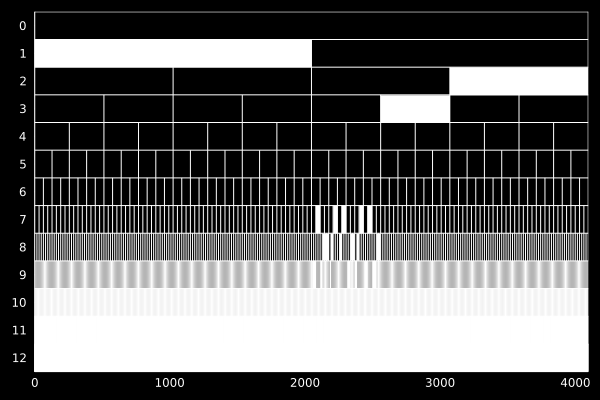

In [12]:
plot_tfbdry(ldb.tree)

The following plot shows the descending discriminant power of coefficients. Based on the elbow rule, it seems like the top 1000 features will be useful.

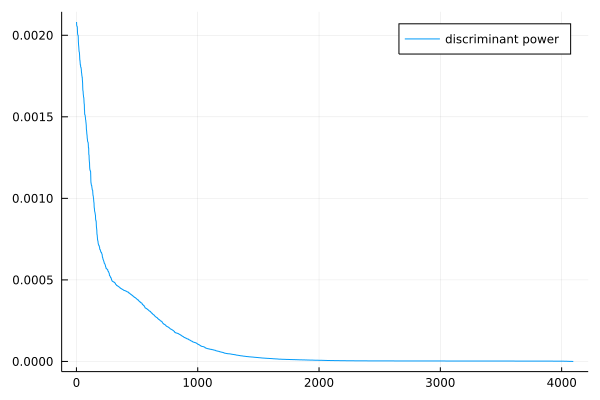

In [13]:
using Plots

plot(ldb.DP[ldb.order], labels="discriminant power")

In [14]:
X_train = change_nfeatures(ldb, X_train, 200)
X_test = WaveletsExt.transform(ldb, X_test);

200×6890 Matrix{Float64}:
 0.174697  0.257886  0.169151   0.551821    …  0.219064   0.302253  0.346621
 0.155286  0.274524  0.152513   0.565685       0.22461    0.324437  0.363259
 0.169151  0.277297  0.14974    0.463086       0.260659   0.282843  0.343848
 0.196881  0.263432  0.169151   0.521318       0.227383   0.28007   0.329983
 0.180243  0.282843  0.163605   0.690469       0.219064   0.302253  0.277297
 0.160832  0.268978  0.163605   0.465859    …  0.230156   0.302253  0.377124
 0.199654  0.257886  0.163605   0.659966       0.188562   0.274524  0.313345
 0.183016  0.227383  0.185789   0.604507       0.227383   0.266205  0.28007
 0.135875  0.266205  0.17747    0.427037       0.263432   0.232929  0.346621
 0.194108  0.296708  0.171924   0.485269       0.235702   0.266205  0.307799
 0.138648  0.293935  0.14974    0.537956    …  0.216291   0.318891  0.35494
 0.17747   0.302253  0.163605   0.427037       0.249567   0.255113  0.321664
 0.146967  0.293935  0.163605   0.665512       0.232

## Fitting a Classifier

In [ ]:
X_train, X_test = X_train', X_test'
y_train, y_test = coerce(y_train, Multiclass), coerce(y_test, Multiclass)

### Decision Tree

In [32]:
Tree = @load DecisionTreeClassifier pkg=DecisionTree verbosity=0
clf = Tree(post_prune=true, merge_purity_threshold=0.8)

DecisionTreeClassifier(
    max_depth = -1,
    min_samples_leaf = 1,
    min_samples_split = 2,
    min_purity_increase = 0.0,
    n_subfeatures = 0,
    post_prune = true,
    merge_purity_threshold = 0.8,
    pdf_smoothing = 0.0,
    display_depth = 5) @141

In [25]:
evalres = MLJ.evaluate(clf, X_train, y_train, measure=cross_entropy)
evalres

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=DecisionTreeClassifier @627`:
│ scitype(X) = AbstractMatrix{Continuous}
│ input_scitype(model) = Table{var"#s46"} where var"#s46"<:Union{AbstractVector{var"#s9"} where var"#s9"<:Count, AbstractVector{var"#s9"} where var"#s9"<:OrderedFactor, AbstractVector{var"#s9"} where var"#s9"<:Continuous}.
└ @ MLJBase C:\Users\LZFun\.julia\packages\MLJBase\KWyqX\src\machines.jl:91
Evaluating over 6 folds: 100%[=========================] Time: 0:00:13


┌───────────────────────────────────┬───────────────┬───────────────────────────
│ _.measure                         │ _.measurement │ _.per_fold               ⋯
├───────────────────────────────────┼───────────────┼───────────────────────────
│ \eLogLoss{Float64} @971\e │ 10.3          │ [10.3, 10.8, 10.3, 10.1, ⋯
└───────────────────────────────────┴───────────────┴───────────────────────────
                                                                1 column omitted
_.per_observation = [[[2.22e-16, 2.22e-16, ..., 36.0], [36.0, 36.0, ..., 36.0], [0.0241, 2.22e-16, ..., 36.0], [0.0047, 1.95, ..., 2.22e-16], [2.3, 2.22e-16, ..., 36.0], [2.22e-16, 36.0, ..., 0.214]]]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [26]:
mach = machine(clf, X_train, y_train)
MLJ.fit!(mach);

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=DecisionTreeClassifier @627`:
│ scitype(X) = AbstractMatrix{Continuous}
│ input_scitype(model) = Table{var"#s46"} where var"#s46"<:Union{AbstractVector{var"#s9"} where var"#s9"<:Count, AbstractVector{var"#s9"} where var"#s9"<:OrderedFactor, AbstractVector{var"#s9"} where var"#s9"<:Continuous}.
└ @ MLJBase C:\Users\LZFun\.julia\packages\MLJBase\KWyqX\src\machines.jl:91
┌ Info: Training Machine{DecisionTreeClassifier,…} @248.
└ @ MLJBase C:\Users\LZFun\.julia\packages\MLJBase\KWyqX\src\machines.jl:342


In [27]:
ŷ_train = MLJ.predict(mach, X_train);
ŷ_test = MLJ.predict(mach, X_test);

Not the best, but in the right direction!

In [28]:
test_acc = Accuracy()(mode.(ŷ_test), y_test)
train_acc = Accuracy()(mode.(ŷ_train), y_train)

println(test_acc)
println(train_acc)

0.6705370101596517
0.9716969395371983


### Random Forest

In [51]:
RForest = @load RandomForestClassifier pkg=ScikitLearn verbosity=0
clf = RForest(n_estimators=200, min_samples_split=20)

RandomForestClassifier(
    n_estimators = 200,
    criterion = "gini",
    max_depth = nothing,
    min_samples_split = 20,
    min_samples_leaf = 1,
    min_weight_fraction_leaf = 0.0,
    max_features = "auto",
    max_leaf_nodes = nothing,
    min_impurity_decrease = 0.0,
    bootstrap = true,
    oob_score = false,
    n_jobs = nothing,
    random_state = nothing,
    verbose = 0,
    warm_start = false,
    class_weight = nothing,
    ccp_alpha = 0.0,
    max_samples = nothing) @860

In [57]:
evalres = MLJ.evaluate(clf, X_train, y_train, measure=cross_entropy)
mach = machine(clf, X_train, y_train)
MLJ.fit!(mach);

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=RandomForestClassifier @860`:
│ scitype(X) = AbstractMatrix{Continuous}
│ input_scitype(model) = Table{var"#s46"} where var"#s46"<:Union{AbstractVector{var"#s9"} where var"#s9"<:Continuous, AbstractVector{var"#s9"} where var"#s9"<:Count}.
└ @ MLJBase C:\Users\LZFun\.julia\packages\MLJBase\KWyqX\src\machines.jl:91
Evaluating over 6 folds: 100%[=========================] Time: 0:01:52
┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=RandomForestClassifier @860`:
│ scitype(X) = AbstractMatrix{Continuous}
│ input_scitype(model) = Table{var"#s46"} where var"#s46"<:Union{AbstractVector{var"#s9"} where var"#s9"<:Continuous, AbstractVector{var"#s9"} where var"#s9"<:Count}.
└ @ MLJBase C:\Users\LZFun\.julia\packages\MLJBase\KWyqX\src\machines.jl:91
┌ Info: Training Machine{RandomForestClassifier,…} @372.
└ @ MLJBase C:\Users\LZFun\.julia\packages\MLJBase\KWyqX\src\machine

In [58]:
ŷ_train = MLJ.predict(mach, X_train);
ŷ_test = MLJ.predict(mach, X_test);

In [59]:
test_acc = Accuracy()(mode.(ŷ_test), y_test)
train_acc = Accuracy()(mode.(ŷ_train), y_train)

println(test_acc)
println(train_acc)

0.7689404934687953
0.954777307788007


### LDA

In [33]:
LDA = @load LDA pkg=MultivariateStats verbosity=0
clf = LDA()

LDA(
    method = :gevd,
    cov_w = SimpleCovariance(false),
    cov_b = SimpleCovariance(false),
    out_dim = 0,
    regcoef = 1.0e-6,
    dist = SqEuclidean(0.0)) @418

In [34]:
evalres = MLJ.evaluate(clf, X_train, y_train, measure=cross_entropy)
evalres

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=LDA @418`:
│ scitype(X) = AbstractMatrix{Continuous}
│ input_scitype(model) = Table{var"#s46"} where var"#s46"<:(AbstractVector{var"#s9"} where var"#s9"<:Continuous).
└ @ MLJBase C:\Users\LZFun\.julia\packages\MLJBase\KWyqX\src\machines.jl:91
Evaluating over 6 folds: 100%[=========================] Time: 0:00:03


1.0985272080167252

In [35]:
mach = machine(clf, X_train, y_train)
MLJ.fit!(mach);

┌ Warning: The scitype of `X`, in `machine(model, X, ...)` is incompatible with `model=LDA @418`:
│ scitype(X) = AbstractMatrix{Continuous}
│ input_scitype(model) = Table{var"#s46"} where var"#s46"<:(AbstractVector{var"#s9"} where var"#s9"<:Continuous).
└ @ MLJBase C:\Users\LZFun\.julia\packages\MLJBase\KWyqX\src\machines.jl:91
┌ Info: Training Machine{LDA,…} @066.
└ @ MLJBase C:\Users\LZFun\.julia\packages\MLJBase\KWyqX\src\machines.jl:342


In [36]:
ŷ_train = MLJ.predict(mach, X_train);
ŷ_test = MLJ.predict(mach, X_test);

In [37]:
test_acc = Accuracy()(mode.(ŷ_test), y_test)
train_acc = Accuracy()(mode.(ŷ_train), y_train)

println(test_acc)
println(train_acc)

0.6284470246734397
0.6425727792983329
